In [ ]:
import torch
from torch import nn
from torch.optim.optimizer import Optimizer
import numpy as np
import scipy
from tqdm import tqdm

# Original PCA

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler


data = load_wine()
scaler = StandardScaler()

X = scaler.fit_transform(data['data'])
y = data['target']

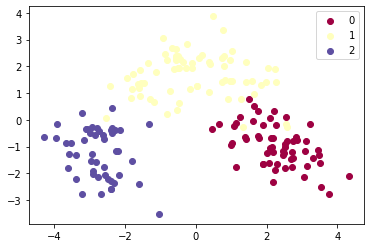

In [ ]:
pca = PCA(n_components = 2)
projected_pca = pca.fit_transform(X)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(y)))]


for label in set(y):
  plt.scatter(projected_pca[np.where(y == label)][:,0], projected_pca[np.where(y == label)][:,1], color=colors[label], label=label)
plt.legend()

# Custom PCA

In [ ]:
def projection(vector, point):
  '''
  Projects a vector on a tangent space of a manifold with the point on it.

  Params:
  -------
  vector : torch.tensor
      Vector we nee to project
  point : torch.tensor
      Point on a manifold

  Returns:
  --------
  vector_R : torch.tensor
      Projection of a vector on a tangent space
  '''
  W_hat = vector.mm(point.t()) - 1/2 * point.mm(point.t().mm(vector.mm(point.t())))
  W = W_hat - W_hat.t()
  vector_R = W.mm(point)
  return vector_R

def retraction(tangent_vector):
  '''
  Retraction from tangent space to manifold
  
  Params:
  -------
  tangent_vector : torch.tensor
      Vector from tangent space

  Returns:
  : torch.tensor
      Point on a manifold
  '''
  u, _, vh = torch.linalg.svd(tangent_vector , full_matrices=False)  
  return u.mm(vh)


In [ ]:
class RiemOpt_custom(Optimizer):

  def __init__(self, parameters, lr = 1e-3):
    defaults = {'lr': lr}
    super().__init__(parameters, defaults)

  def step(self, closure = None):
        loss = None
        if closure is not None:
          loss = closure()

        with torch.no_grad():
          
            for group in self.param_groups:
                if "step" not in group:
                    group["step"] = 0

                for point in group["params"]:
                    grad = point.grad.data
                    if grad is None:
                        continue
                    
                    # Projection 
                    grad_R = projection(grad, point)

                    # Step on tangent space
                    step_vector = point - group['lr']* grad_R

                    # Retraction
                    point_target = retraction(step_vector)
                    point.copy_(point_target)
                    point.requires_grad = True
                    
        return loss

In [ ]:
class PCA_custom(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        # Define all Layers Here
        Q, _ = np.linalg.qr(np.random.rand(input_shape, input_shape) * np.sqrt(2 / output_shape))
        Q = torch.tensor(np.round(Q, 14)[:,:output_shape], )
        self.P = nn.Parameter(Q, requires_grad=True)
        print(f'PCA matrix size {self.P.size()}')

    def forward(self, x):
        # Connect the layer Outputs here to define the forward pass
        x_1 = self.P.t().mm(x)  # (n_dim_new x n_dim_old) x (n_dim_old x n_samples)
        return x_1

In [ ]:
def pca_loss(P, X):
  return torch.pow(torch.norm(input= (X - P.mm(torch.mm(P.t(), X))), p='fro' ), 2)

## Training

In [ ]:
# (n_samples x n_dim_old)
X.shape

(178, 13)

In [ ]:
# Transform to (n_dim_old x n_samples)
tensor_data = torch.tensor(X.T)

pca_custom = PCA_custom(tensor_data.shape[0], 2)

criterion = pca_loss

optimizer = RiemOpt_custom(pca_custom.parameters(), lr=1e-4)

criterion(pca_custom.P, tensor_data)

PCA matrix size torch.Size([13, 2])


tensor(1634.0133, dtype=torch.float64, grad_fn=<PowBackward0>)

In [ ]:
# Training loop

n_epochs = 10
for epoch in range(n_epochs):
  pca_custom.train()
  count = 0
  count_loss = 0
  prev = pca_custom.P
  for i in range(100):
    loss = criterion(pca_custom.P, tensor_data)
    loss.backward()
    optimizer.step()
    
    count += 1
    count_loss += loss.data
  # print(f'WHAT? {prev == pca_custom.P}')
  print(f'loss {count_loss / count}')
pca_custom.eval()

loss 1065.8909168056468
loss 1031.8973304237663
loss 1031.8973304205167
loss 1031.897330420518
loss 1031.897330420518
loss 1031.897330420518
loss 1031.897330420518
loss 1031.897330420518
loss 1031.897330420518
loss 1031.897330420518


PCA_custom()

In [ ]:
projected_pca_custom = pca_custom(tensor_data)
projected_pca_custom.size()

torch.Size([2, 178])

# Plotting and comparing the results

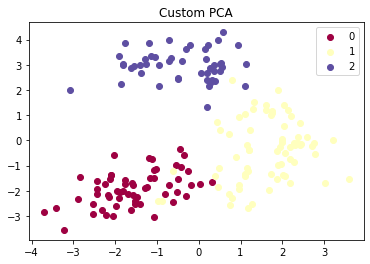

In [ ]:
projected_pca_custom = pca_custom(tensor_data).t().detach().numpy()

for label in set(y):
  plt.scatter(projected_pca_custom[np.where(y == label)][:,0], projected_pca_custom[np.where(y == label)][:,1], color=colors[label], label=label)
plt.title('Custom PCA')
plt.legend()

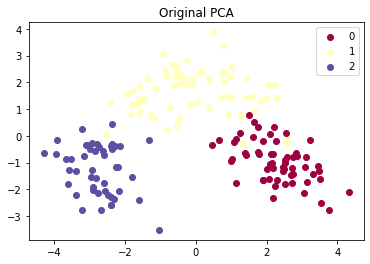

In [ ]:
for label in set(y):
  plt.scatter(projected_pca[np.where(y == label)][:,0], projected_pca[np.where(y == label)][:,1], color=colors[label], label=label)
plt.title('Original PCA')
plt.legend()